In [9]:
import sys
import os

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import torch

# import some common libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

def cv2_imshow( im ):
    cv2.imshow('',im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

things = MetadataCatalog.get("coco_2017_train").thing_classes
print(things)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [10]:
##### CAMERA CALIBRATION CONFIG - this configuration comes from how we set up Cameras in CARLA
baseline_F = 0.8 # 80cm on top car
baseline_LC = np.sqrt([0.2*0.2 *2])[0] # left corner
baseline_RC = np.sqrt([0.2*0.2 *2])[0] # right corner
baseline_L = 0.5 # left side
baseline_R = 0.5 # right side

# rotation matrices

# translation matrices (first swap then rotate then translate : F * R)
translate_F = torch.tensor([[1.,0,0,-0.3],[0,1.,0,0.4],[0,0,1.,-1.0],[0,0,0,1.]])

# {"x": z, "y": x, "z": y } Switch between CARLA UE and image coordinate system
swap_axes = torch.tensor([[0,0,1.0,0],[1,0,0,0],[0,1.0,0,0],[0,0,0,1.]])

# full transforms matrices
transform_F = torch.mm(translate_F, swap_axes)

# camera properties
fov=90
W=1280
H=720

fov = fov / 360. * 2. * np.pi
f = W / (2. * np.tan(fov / 2.))  # focus length

In [11]:
########### CONFIGURE DETECTRON
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

In [12]:
########### CONFIGURE STEREO MATCHER
num_disp = 128
window_size = 11
stereo = cv2.StereoSGBM_create(numDisparities = num_disp, blockSize = window_size )
stereo.setUniquenessRatio(5)

In [13]:
########### CONFIGURE PATH AND JSON LOGGER
from actorlogger import ActorLogger, Frame
path = "/home/najib/Thesis/Rendering/" + str(4)
subpath = path + "/out/"
saveimpath = path + "/det/"
os.makedirs(saveimpath, exist_ok=True)
actorLogger = ActorLogger(path)

In [14]:
# Depth image saver
dpi = 72
figsize = W / float(dpi), H / float(dpi)
def saveDepth(disparity, path):
    fig = plt.figure(figsize=figsize,frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(disparity, aspect='auto')
    plt.savefig(path, bbox_inches='tight',transparent=True, pad_inches=0)
    plt.close()

In [15]:
import re
from PIL import Image
import time

In [16]:
## First frame
sortedPaths = sorted(os.listdir(subpath))
frame_id = int(re.search(r'\d+', sortedPaths[0]).group())
print("First frame: ", frame_id, " last frame: ", re.search(r'\d+', sortedPaths[-1]).group())

start_time = time.time()

fpsl = []

while(os.path.exists((subpath + str(frame_id) + 'FL.jpg'))):
    frame = Frame(frame_id)
    print("Processing frame ", frame_id)
    lasts = fpsl[-15:]
    if lasts:
        print("FPS avg: ", np.mean(lasts))

    # Read front stereo images
    imgL = cv2.imread(subpath + str(frame_id) + 'FL.jpg')
    imgR = cv2.imread(subpath + str(frame_id) + 'FR.jpg')

    # Hide ego car from image
    imgL[620:H, 360:W] = [0,0,0]
    imgR[620:H, 0:900] = [15,15,15]


    # Calculate disparity with stereo block matching algorithm
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    disparity = stereo.compute(grayL, grayR).astype(np.float32) / 16.0
    # save image
    saveDepth(disparity, ('%s/%d%s.jpg' % (saveimpath, frame_id, "DP")))

    # Predict detections with detectron2
    outputs = predictor(imgL)
    
    # save image
    v = Visualizer(imgL[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    detim = v.get_image()
    Image.fromarray(detim, 'RGB').save(('%s/%d%s.jpg' % (saveimpath, frame_id, "DET")), 'JPEG', quality=85)
    

    # Detect actors
    for i in range(0, len(outputs["instances"])):
        
        if(outputs["instances"].pred_classes[i] not in (0,1,2,3,4,5,6,7)): # Detect only these classes
            continue

        # Mask actor depth
        mask = outputs["instances"].pred_masks[i]
        masked = torch.tensor(disparity)[mask]
        nonnegative = masked > 0  # negative values in depth map mean unmatched regions
        disparities = masked[nonnegative]

        if(disparities.nelement() != 0):
            mean_disparity = disparities.mode().values # Mean of depth
            if torch.isnan(mean_disparity):
                mean_disparity = torch.tensor(0.1)
        else:
            mean_disparity = torch.tensor(0.1)
           
            
        # Inverse projection
        [[cx, cy]] = outputs["instances"].pred_boxes[i].get_centers()
        dx = cx - W/2
        dy = cy - H/2
        z = f*baseline_F/mean_disparity
        x = dx*z/f
        y = dy*z/f
        
        # Swap axes to RL coordinates and translate
        pos = torch.tensor([x,y,z,1])
        [x,y,z, _] = torch.mv(transform_F,pos)
        
        x = float(x)
        y = float(y)
        z = float(z)
        frame.addActor("", things[outputs["instances"].pred_classes[i]], 0, {"x": x, "y": y, "z": z })


    actorLogger.addFrame(frame)
    frame_id += 1
    
    fpsl.append(1.0 / (time.time() - start_time))
    start_time = time.time()  

actorLogger.save()


First frame:  110  last frame:  262
Processing frame  110
Processing frame  111
FPS avg:  0.5162625057496816
Processing frame  112
FPS avg:  0.5086006249720192
Processing frame  113
FPS avg:  0.5110348016472169
Processing frame  114
FPS avg:  0.5133464135018597
Processing frame  115
FPS avg:  0.5077944332385987
Processing frame  116
FPS avg:  0.4999775323908499
Processing frame  117
FPS avg:  0.4973069818997459
Processing frame  118
FPS avg:  0.4985737521997377


KeyboardInterrupt: 

tensor(660.6708, device='cuda:0') tensor(292.9538, device='cuda:0')
41.72052001953125 1.7571864128112793 -5.402059078216553


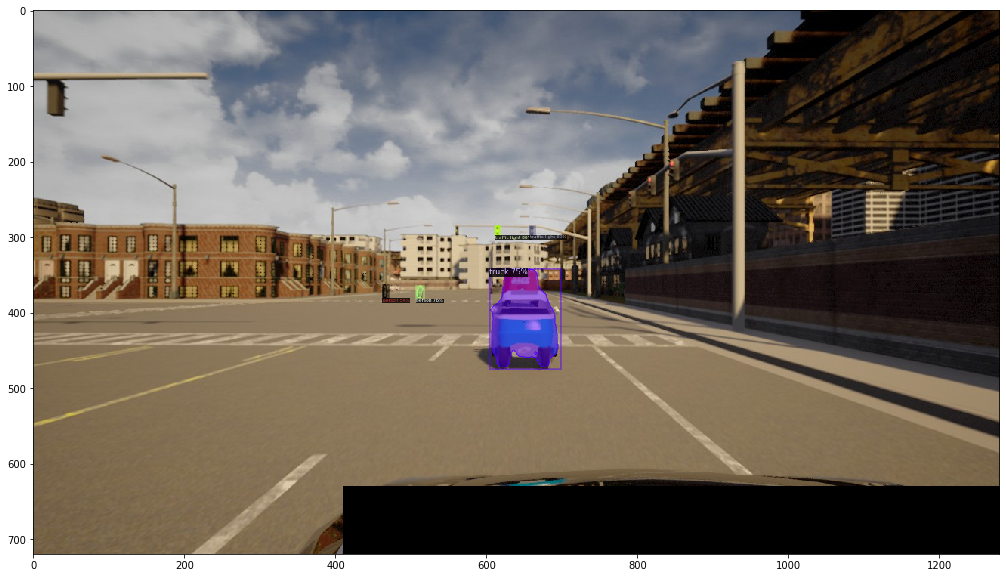

In [13]:
imgL = cv2.imread('/home/najib/Thesis/Rendering/3/out/260FL.jpg')
imgR = cv2.imread('/home/najib/Thesis/Rendering/3/out/260FR.jpg')

imgL[630:H, 410:W] = [0,0,0]
imgR[630:H, 0:880] = [15,15,15]

outputs = predictor(imgL)
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
# outputs["instances"].pred_boxes[0]

i =3
[[cx, cy]] = outputs["instances"].pred_boxes[i].get_centers()
print(cx, cy)

grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
disp = stereo.compute(grayL, grayR).astype(np.float32) / 16.0
disparity = (disp)

mask = outputs["instances"].pred_masks[i]
masked = torch.tensor(disparity)[mask]
nonnegative = masked > 0  # negative values in depth map mean unmatched regions
mean_disparity = masked[nonnegative].mean()

if(torch.isnan(mean_disparity)):
    mean_disparity = torch.tensor(0.1)

# Inverse projection
dx = cx - W/2
dy = cy - H/2
z = f*baseline_F/mean_disparity
x = dx*z/f
y = dy*z/f

# Swap axes to RL coordinates and translate
pos = torch.tensor([x,y,z,1])
[x,y,z, _] = torch.mv(transform_F,pos)

x = float(x)
y = float(y)
z = float(z)

print(x,y,z)


v = Visualizer(imgL[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
detim = v.get_image()
plt.figure(figsize=(20,10))
plt.imshow(detim)